# Notebook for training TopoNEt model on MEG data for predicting the task being performed

Model architecture - https://arxiv.org/pdf/1611.08024

Training data - MEG data recorder while people were performing different tasks.

In [145]:
import copy
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchmetrics
from pymatreader import read_mat
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

## First experiment
0.5 seconds before the actual experiment has started. Participant is informed, what he needs to pay attention to.
Only one participant is used for training and testing.

### Loading data

In [43]:
def load_first_500ms(file_path: str, label: int) -> list:
    """
    Loads trials from a file and takes the first 500ms of data from them.
    :return: (500ms_of_trial, label) where label is ground truth for classification.
    """
    data = read_mat(file_path)
    cut_data = []
    for trial in data['finalStruct']['trial']:
        cut_trial = np.empty([0, 500])
        for sensor in trial:
            cut_trial = np.append(cut_trial, [sensor[:500]], axis=0)
        cut_data.append((np.float32(cut_trial), label))
    return cut_data

In [174]:
SUBJECT_NUMBER = '01' # We can train our models on different participants

data = load_first_500ms(f'/mnt/diska/baldauf/Subject_{SUBJECT_NUMBER}_OnsetStim_BOT_scoutTimeSeriesNew.mat', 0) + \
    load_first_500ms(f'/mnt/diska/baldauf/Subject_{SUBJECT_NUMBER}_OnsetStim_TOP_scoutTimeSeriesNew.mat', 1)

# Since we have a small amount of data, we will only use train and test
test_size = int(0.1 * len(data))
train_dataset, test_dataset = random_split(data, [len(data) - test_size, test_size])

torch.manual_seed(42) # for reproducibility
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

f'Size of training dataset - {len(data) - test_size} trials'

'Size of training dataset - 219 trials'

### Model classes

Here we implement EEGNet, but with some modifications, due to the nature of our data and need to use topographical constraints.

In [172]:
class ConstrainedConv2d(nn.Conv2d):
    """
    Implementation of maximum norm constraint for Conv2D layer
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.conv2d(x, self.weight.clamp(max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class ConstrainedLinear(nn.Linear):
    """
    Implementation of maximum norm constraint for Linear layer
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(x, self.weight.clamp(max=0.5), self.bias)

class EEGNet(nn.Module):
    def __init__(self, sensors: int, samples: int, num_classes: int, f1: int, depth: int, f2: int, dropout: float):
        super().__init__()
        self.block1 = nn.Sequential(
            # This layer does 1d convolutions on data from sensors.
            # Since we have only 500ms of data we set kernel length at 250 (we look at 250ms at once).
            # We can capture patterns with frequency above 4Hz (because data sampling is 1000Hz, 1000 / 250 = 4).
            nn.Conv2d(in_channels=1, out_channels=f1, kernel_size=(1, 64), padding='same',
                      bias=False),
            nn.BatchNorm2d(f1),

            # Depthwise convolution. Looks for spatial patterns and combines all data from sensors together.
            # We use our own implementation of convolution layer because pytorch doesn't have weight constraints implemented.
            ConstrainedConv2d(in_channels=f1, out_channels=f1*depth, kernel_size=(sensors, 1), padding='valid',
                              groups=f1, bias=False),
            nn.BatchNorm2d(f1*depth),
            nn.ELU(),

            # Average pooling to reduce sampling rate
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(dropout),
        )
        self.block2 = nn.Sequential(
            # Implementation of Separable convolution.
            # First we use Depthwise convolution (separately for all channels).
            nn.Conv2d(in_channels=f1*depth, out_channels=f1*depth, kernel_size=(1, 16), padding='same',
                      groups=f1*depth, bias=False),

            # Next we combine channels with Pointwise convolution.
            nn.Conv2d(in_channels=f1*depth, out_channels=f2, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(f2),
            nn.ELU(),

            # Average pooling to reduce sampling rate
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(dropout),
            nn.Flatten(),
        )
        # We have to add one dense layer in order to implement topographical constraints.
        # We use our own implementation again to introduce weights constraint.
        self.linear = ConstrainedLinear(in_features=f2*(samples//32), out_features=36)

        # Classifier layer
        self.classifier = nn.Linear(in_features=36, out_features=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = self.linear(x)
        return self.classifier(x)


### Sanity check
Checking, that forward pass works and model data shapes are the ones we expect

In [64]:
test_data, label = next(iter(test_loader))
test_sample = test_data[0].unsqueeze(0).unsqueeze(0)
print(f'The shape of the test sample is {test_sample.shape}')

test_model = EEGNet(sensors=test_sample.shape[2], samples=test_sample.shape[3], num_classes=2, f1=8, depth=2, f2=16, dropout=0.5)
test_model.eval()
with torch.inference_mode():
    x = test_model.block1(test_sample)
    print(f'Expected shape - (1, 16, 1, 125), we have - {x.shape}')
    x = test_model.block2(x)
    print(f'Expected shape - (1, 240), we have - {x.shape}')
    x = test_model.linear(x)
    print(f'Expected shape - (1, 36), we have - {x.shape}')
    x = test_model.classifier(x)
    print(f'Expected shape - (1, 2), we have - {x.shape}')

The shape of the test sample is torch.Size([1, 1, 360, 500])
Expected shape - (1, 16, 1, 125), we have - torch.Size([1, 16, 1, 125])
Expected shape - (1, 240), we have - torch.Size([1, 240])
Expected shape - (1, 36), we have - torch.Size([1, 36])
Expected shape - (1, 2), we have - torch.Size([1, 2])


### Spatial loss implementation
Imagines, that neurons on the layer have a spatial organization and calculates average distance between neighbouring weights associated with those neurons.

Inspired by brain neuronal organization.

In [81]:
def spatial_loss(weights: torch.Tensor, grid_width: int):
    """
    Calculates the spatial loss for a set of weights.
    :param weights: weights tensor.
    :param grid_width: width of our imagined grid. Works with any grid of rectangular shape.
    """
    # This is a transformation which helps to calculate indexes of "neighbouring" neurons.
    neighbour_transformations = np.array([-grid_width - 1, -grid_width, -grid_width + 1, -1, +1, grid_width - 1, grid_width, grid_width + 1])

    sp_loss = 0.0
    num_neighbours = 0
    for i in range(weights.shape[0]):
        # We calculate indexes and filter those out of scope.
        neighbours = neighbour_transformations + i
        neighbour_filter = (neighbours >= 0) & (neighbours < weights.shape[0])
        neighbours = neighbours[neighbour_filter]

        # We calculate squared distance between weights of the neuron and its neighbours.
        for neighbour in neighbours:
            distance = torch.norm(weights[i] - weights[neighbour])
            sp_loss += distance

        num_neighbours += len(neighbours)

    # We return an average distance.
    return sp_loss / num_neighbours

### Train and Test steps

In [126]:
def train_step(model, train_data, loss_fn, optimizer, lambda_regularization=0.0, spatial=False, spatial_grid_width=6):
    """
    Performs one training step.
    :param model:
    :param train_data:
    :param loss_fn:
    :param optimizer:
    :param lambda_regularization: regularization parameter for spatial loss.
    :param spatial: True, if we need to calculate spatial loss.
    :param spatial_grid_width: width of grid for spatial loss.
    :return: Average loss during the training cycle.
    """
    model.train()

    avg_loss = 0.0
    for X, y in train_data:
        X, y = X.to(DEVICE), y.to(DEVICE)
        X = X.unsqueeze(1)
        # Forward pass
        y_logits = model(X)
        # Performance loss
        loss = loss_fn(y_logits, y)
        # Addition of spatial loss
        if spatial:
            loss += lambda_regularization * spatial_loss(model.linear.weight, spatial_grid_width)
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Parameters update
        optimizer.step()

        # Save the loss
        avg_loss += loss

    return avg_loss / len(train_data)

def test_step(model, test_data, loss_fn, lambda_regularization=0.0, spatial=False, spatial_grid_width=6):
    """
    Performs one test step.
    :param model:
    :param test_data:
    :param loss_fn:
    :param lambda_regularization: regularization parameter for spatial loss.
    :param spatial: True, if we need to calculate spatial loss.
    :param spatial_grid_width: width of grid for spatial loss.
    :return: model predictions on test data, targets and average loss during the test cycle.
    """
    model.eval()

    y_preds = torch.empty(0, device=DEVICE)
    y_targets = torch.empty(0, device=DEVICE)
    avg_loss = 0.0
    with torch.inference_mode():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            X = X.unsqueeze(1)
            # Forward pass
            y_logits = model(X)
            # Performance loss
            loss = loss_fn(y_logits, y)
            # Addition of spatial loss
            if spatial:
                loss += lambda_regularization * spatial_loss(model.linear.weight, spatial_grid_width)
            # Making predictions
            yp = torch.argmax(y_logits, dim=1)
            # Saving predictions
            y_preds = torch.cat((y_preds, yp), dim=0)
            # Saving targets
            y_targets = torch.cat((y_targets, y), dim=0)

            avg_loss += loss

    return y_preds, y_targets, avg_loss / len(test_data)


### Useful functions

In [116]:
def accuracy_plot(train_acc, valid_acc):
    """
    Function to plot the change of accuracy during training.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='red', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def loss_plot(train_loss, valid_loss):
    """
    Function to plot the change of loss during training.
    """
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='red', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='blue', linestyle='-',
        label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

### Training loop

In [125]:
def train_model(model, train_loader, test_loader, epochs, loss_fn, optimizer,
                spatial=False, lambda_regularization=0.0, spatial_grid_width=6):

    # Since dataset is more or less balanced, we will use accuracy metric
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(DEVICE)
    best_loss = float('inf')
    best_model = {}
    loss_history = {
        'train_loss': [],
        'valid_loss': [],
    }
    for epoch in tqdm(range(epochs)):

        train_loss = train_step(model, train_loader, loss_fn, optimizer, lambda_regularization=lambda_regularization,
                                spatial=spatial, spatial_grid_width=spatial_grid_width)

        predictions, targets, test_loss = test_step(model, test_loader, loss_fn, lambda_regularization=lambda_regularization,
                                                    spatial=spatial, spatial_grid_width=spatial_grid_width)
        acc = accuracy(predictions, targets)

        print(f'After epoch {epoch}, average training loss is {train_loss:.4f}, average test loss is {test_loss:.4f} and accuracy on test set is {acc * 100:.2f}%')

        loss_history['train_loss'].append(train_loss.item())
        loss_history['valid_loss'].append(test_loss.item())

        # Saving model with the lowest test loss
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = {
                'epoch': epoch,
                'state_dict': copy.deepcopy(model.state_dict()),
                'accuracy': acc,
            }

    return best_model, loss_history

### Training hyperparameters

In [127]:
RANDOM_SEED = 42 # For reproducibility. To later models with different random initializations.
SPATIAL_REGULARIZATION = 0.3 # I'm using same regularization as in previous experiment
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### EEGNet without spatial loss

Initialization

In [134]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = EEGNet(sensors=360, samples=500, num_classes=2, f1=8, depth=2, f2=16, dropout=0.5).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training

In [135]:
best_model, loss_history = train_model(model, train_loader, test_loader, epochs=50, loss_fn=loss_fn, optimizer=optimizer)

  0%|          | 0/50 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.6954, average test loss is 0.6912 and accuracy on test set is 54.17%
After epoch 1, average training loss is 0.6948, average test loss is 0.6914 and accuracy on test set is 54.17%
After epoch 2, average training loss is 0.6966, average test loss is 0.6917 and accuracy on test set is 54.17%
After epoch 3, average training loss is 0.6890, average test loss is 0.6920 and accuracy on test set is 54.17%
After epoch 4, average training loss is 0.6992, average test loss is 0.6921 and accuracy on test set is 54.17%
After epoch 5, average training loss is 0.6912, average test loss is 0.6920 and accuracy on test set is 54.17%
After epoch 6, average training loss is 0.6979, average test loss is 0.6920 and accuracy on test set is 54.17%
After epoch 7, average training loss is 0.6948, average test loss is 0.6928 and accuracy on test set is 54.17%
After epoch 8, average training loss is 0.6943, average test loss is 0.6922 and accuracy on test set is 54.17%
A

Results

Best model appeared at the epoch 0 with an accuracy of 54.17%


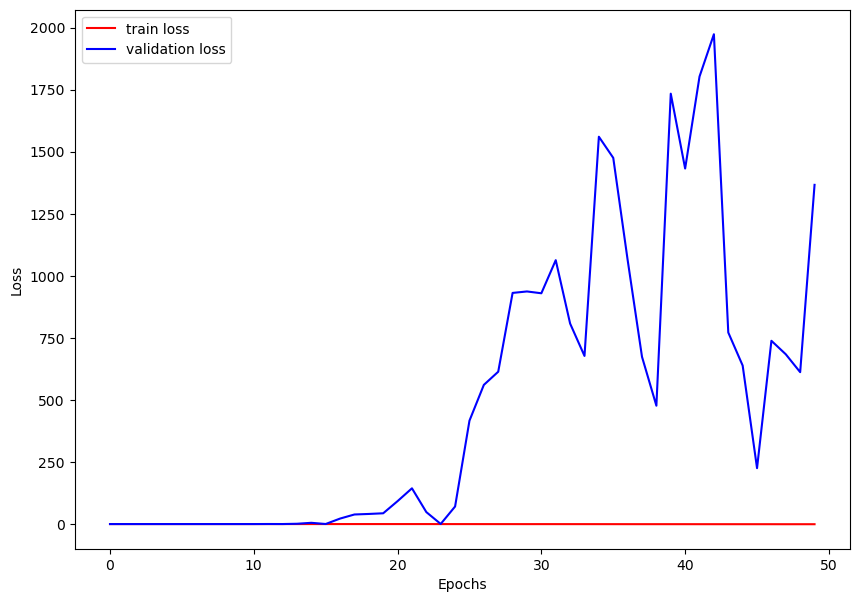

In [136]:
loss_plot(loss_history['train_loss'], loss_history['valid_loss'])

print(f'Best model appeared at the epoch {best_model["epoch"]} with an accuracy of {best_model["accuracy"] * 100:.2f}%')

### EEGNet with spatial loss

Initialization

In [137]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = EEGNet(sensors=360, samples=500, num_classes=2, f1=8, depth=2, f2=16, dropout=0.5).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training

In [138]:
best_model, loss_history = train_model(model, train_loader, test_loader, epochs=50, loss_fn=loss_fn, optimizer=optimizer,
                                       lambda_regularization=SPATIAL_REGULARIZATION, spatial=True, spatial_grid_width=6)

  0%|          | 0/50 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.9262, average test loss is 0.9028 and accuracy on test set is 54.17%
After epoch 1, average training loss is 0.8941, average test loss is 0.8742 and accuracy on test set is 54.17%
After epoch 2, average training loss is 0.8663, average test loss is 0.8487 and accuracy on test set is 54.17%
After epoch 3, average training loss is 0.8365, average test loss is 0.8254 and accuracy on test set is 54.17%
After epoch 4, average training loss is 0.8206, average test loss is 0.8041 and accuracy on test set is 54.17%
After epoch 5, average training loss is 0.7961, average test loss is 0.7852 and accuracy on test set is 54.17%
After epoch 6, average training loss is 0.7819, average test loss is 0.7686 and accuracy on test set is 54.17%
After epoch 7, average training loss is 0.7635, average test loss is 0.7546 and accuracy on test set is 54.17%
After epoch 8, average training loss is 0.7523, average test loss is 0.7447 and accuracy on test set is 54.17%
A

Results

Best model appeared at the epoch 12 with an accuracy of 54.17%


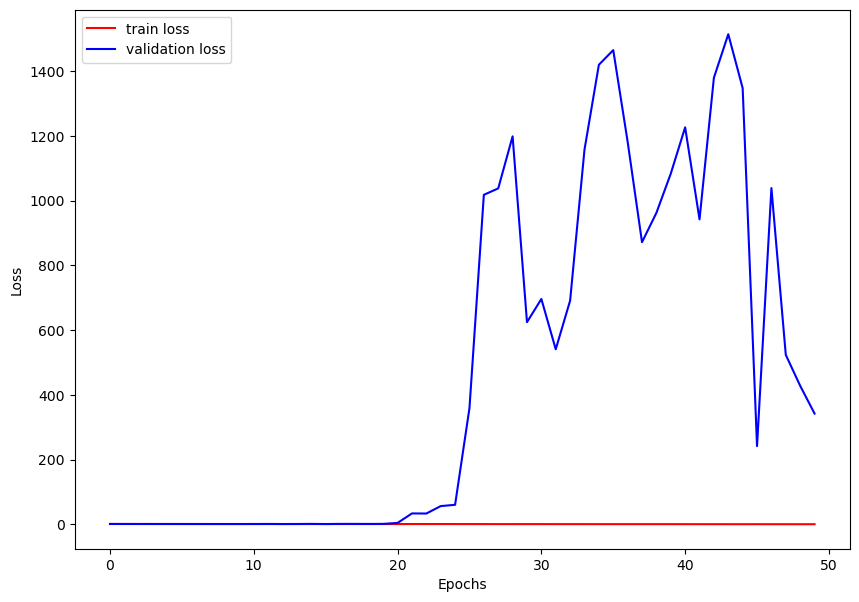

In [139]:
loss_plot(loss_history['train_loss'], loss_history['valid_loss'])

print(f'Best model appeared at the epoch {best_model["epoch"]} with an accuracy of {best_model["accuracy"] * 100:.2f}%')

### Sanity check - synthetic dataset
We create synthetic dataset with different sine patterns in order to check, if our model can learn at all.

In [167]:
pattern_freq_1 = [32, 40, 64] # Sine frequencies for the first pattern
pattern_freq_2 = [41, 57, 73] # Sine frequencies for the second pattern

synthetic_dataset = []
for _ in range(500): # Amount of data for the first pattern
    trial = np.empty([0, 200])
    for _ in range(100):
        start = random.random() * np.pi # To start from random phase
        time = np.linspace(start, start + np.pi, 200)
        data = np.zeros(200)
        for pattern in pattern_freq_1:
            data += np.sin(2 * np.pi * pattern * time) # Here we sum sine patterns together
        data = np.reshape(data, (1, 200))
        trial = np.append(trial, data, axis=0)
    synthetic_dataset.append((np.float32(trial), 0))

for _ in range(500): # Same for the second pattern
    trial = np.empty([0, 200])
    for _ in range(100):
        start = random.random() * np.pi
        time = np.linspace(start, start + np.pi, 200)
        data = np.zeros(200)
        for pattern in pattern_freq_2:
            data += np.sin(2 * np.pi * pattern * time)
        data = np.reshape(data, (1, 200))
        trial = np.append(trial, data, axis=0)
    synthetic_dataset.append((np.float32(trial), 1))

syn_train_dataset, syn_test_dataset = random_split(synthetic_dataset, [len(synthetic_dataset) - test_size, test_size])

syn_train_loader = DataLoader(syn_train_dataset, batch_size=32, shuffle=True)
syn_test_loader = DataLoader(syn_test_dataset, batch_size=32)

In [168]:
model = EEGNet(sensors=100, samples=200, num_classes=2, f1=8, depth=2, f2=16, dropout=0.5).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [169]:
best_model, loss_history = train_model(model, syn_train_loader, syn_test_loader, epochs=5, loss_fn=loss_fn, optimizer=optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.3370, average test loss is 0.0575 and accuracy on test set is 100.00%
After epoch 1, average training loss is 0.0123, average test loss is 0.0023 and accuracy on test set is 100.00%
After epoch 2, average training loss is 0.0027, average test loss is 0.0013 and accuracy on test set is 100.00%
After epoch 3, average training loss is 0.0018, average test loss is 0.0008 and accuracy on test set is 100.00%
After epoch 4, average training loss is 0.0014, average test loss is 0.0008 and accuracy on test set is 100.00%


Best model appeared at the epoch 3 with an accuracy of 100.00%


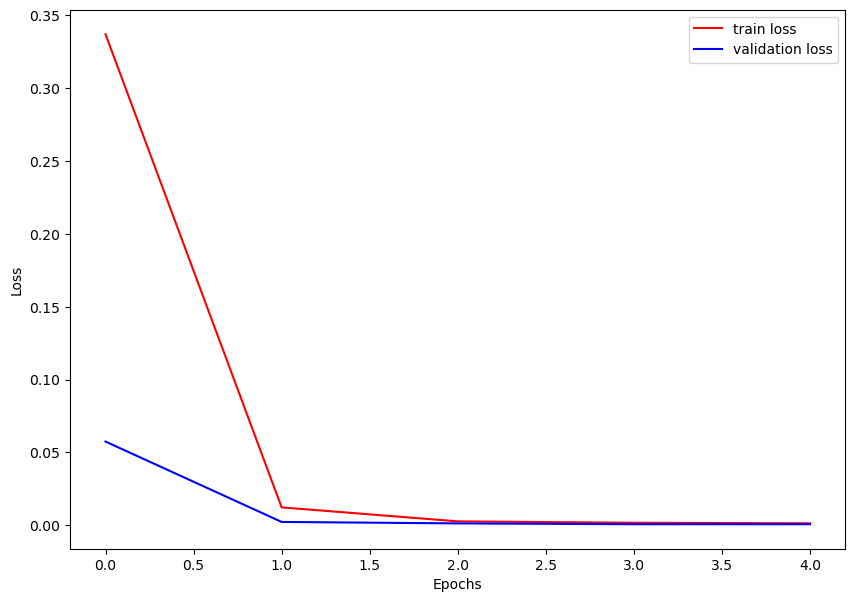

In [170]:
loss_plot(loss_history['train_loss'], loss_history['valid_loss'])

print(f'Best model appeared at the epoch {best_model["epoch"]} with an accuracy of {best_model["accuracy"] * 100:.2f}%')

### Reducing size of filter window in the first layer to 64

In [176]:
model = EEGNet(sensors=360, samples=500, num_classes=2, f1=8, depth=2, f2=16, dropout=0.1).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [177]:
best_model, loss_history = train_model(model, train_loader, test_loader, epochs=10, loss_fn=loss_fn, optimizer=optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.6934, average test loss is 0.6983 and accuracy on test set is 37.50%
After epoch 1, average training loss is 0.6936, average test loss is 0.6974 and accuracy on test set is 37.50%
After epoch 2, average training loss is 0.6934, average test loss is 0.6977 and accuracy on test set is 37.50%
After epoch 3, average training loss is 0.6923, average test loss is 0.6984 and accuracy on test set is 37.50%
After epoch 4, average training loss is 0.6936, average test loss is 0.6992 and accuracy on test set is 37.50%
After epoch 5, average training loss is 0.6941, average test loss is 0.6991 and accuracy on test set is 37.50%
After epoch 6, average training loss is 0.6929, average test loss is 0.6973 and accuracy on test set is 37.50%
After epoch 7, average training loss is 0.6949, average test loss is 0.6924 and accuracy on test set is 62.50%
After epoch 8, average training loss is 0.6936, average test loss is 0.6784 and accuracy on test set is 62.50%
A

Best model appeared at the epoch 8 with an accuracy of 62.50%


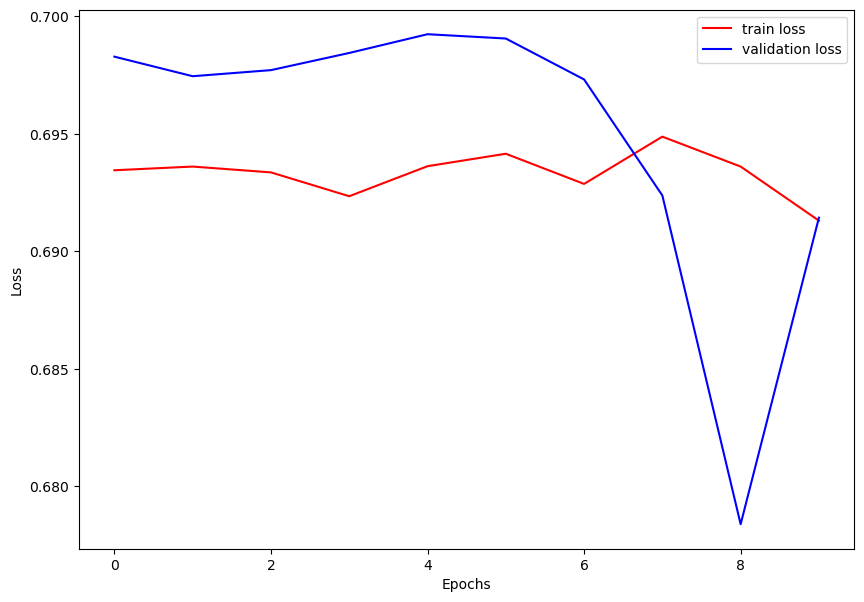

In [178]:
loss_plot(loss_history['train_loss'], loss_history['valid_loss'])

print(f'Best model appeared at the epoch {best_model["epoch"]} with an accuracy of {best_model["accuracy"] * 100:.2f}%')

Possible next steps:
1. Try training with all participant data
2. Train with full data (whole experiment)
3. It would be good to train with different random seeds and try cross-validation if models will start learning something.